# PyTorch and CIFAR10 data analysis

I trained a custom ResNet9 model to recognize images from the CIFAR10 dataset with PyTorch.

David Page designed this model and got fantastic results for the [Stanford DAWNBench competition](https://dawn.cs.stanford.edu/benchmark/index.html). Here is a [blog post](https://myrtle.ai/learn/how-to-train-your-resnet/) that talks about the model and here is the [source code](https://github.com/davidcpage/cifar10-fast/tree/d31ad8d393dd75147b65f261dbf78670a97e48a8).

Using pyJoules, I logged the energy consumed in every epoch. This notebook will analyze 51 runs, each consisting of 24 epochs.

The experiments were run in the Chifflot 8 computer using its core 1 and a single NVIDIA V100 GPU.

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

In [12]:
sns.set_theme(style='white', palette='pastel')

In [13]:
DATA_DIRNAME = 'csv'

MODEL_INDEX = 0
EXPERIMENT_INDEX = 5
RUN_INDEX = None  # If None, all runs will be loaded

In [14]:
model_dirnames_all = sorted(
    [file.name for file in os.scandir(DATA_DIRNAME)
     if file.is_dir() and not file.name.startswith('.')])
model_dirname = model_dirnames_all[MODEL_INDEX]

print(f'Selected model\n- {model_dirname}\n')
print(f'Models\n- {f"{chr(10)}- ".join(model_dirnames_all)}')

Selected model
- fast

Models
- fast
- fast-mnist
- torchskeleton-defworker
- torchskeleton-noworker


In [15]:
experiment_dirnames_all = sorted(
    [file.name for file
     in os.scandir(os.path.join(DATA_DIRNAME, model_dirname))
     if file.is_dir() and not file.name.startswith('.')])
experiment_dirname = experiment_dirnames_all[EXPERIMENT_INDEX]

print(f'Selected experiment\n- {experiment_dirname}\n')
print(f'Experiments\n- {f"{chr(10)}- ".join(experiment_dirnames_all)}')

Selected experiment
- 2021-10-22-10-10-55-gpu-core1-nohyper

Experiments
- 2021-10-14-09-16-15-gpu
- 2021-10-14-12-30-14-gpu
- 2021-10-18-15-25-46-gpu
- 2021-10-19-11-31-50-nogpu
- 2021-10-21-15-02-56-gpu-cpu1
- 2021-10-22-10-10-55-gpu-core1-nohyper
- 2021-10-22-12-07-40-gpu-core1-hyper
- 2021-10-25-14-59-44-gpu-core1,3,5,7-nohyper


In [16]:
run_filenames_all = sorted(
    [file.name for file
     in os.scandir(os.path.join(
         DATA_DIRNAME,
         model_dirname,
         experiment_dirname))
     if file.is_file() and not file.name.startswith('.')])

if RUN_INDEX is None:
    run_filenames = run_filenames_all
    print(f'Selected runs\n- All\n')
else:
    run_filenames = [run_filenames_all[RUN_INDEX]]
    print(f'Selected run\n- {run_filenames[0]}\n')

if len(run_filenames) > 8:
    print('Runs\n- ', end='')
    print('\n- '.join(run_filenames[:4]))
    print('.\n.\n.\n- ', end='')
    print('\n- '.join(run_filenames[-4:]))
else:
    print(f'Runs\n- {f"{chr(10)}- ".join(run_filenames)}')

Selected runs
- All

Runs
- run-00.csv
- run-01.csv
- run-02.csv
- run-03.csv
.
.
.
- run-47.csv
- run-48.csv
- run-49.csv
- run-50.csv


In [17]:
df = pd.concat(
    [pd.read_csv(
        os.path.join(
            DATA_DIRNAME,
            model_dirname,
            experiment_dirname,
            run_filename))
     for run_filename in run_filenames])

In [18]:
# Remove first epoch as initialization makes it take longer
df = df.iloc[1:]

In [19]:
df = df.reset_index(drop=True)

## First columns of the dataframe

The first epoch is removed as initialization causes it to take considerably longer.

In [20]:
df.head()

,epoch,duration,train acc,valid acc,package_0 energy,package_1 energy,dram_0 energy,dram_1 energy,nvidia_gpu_0 energy,nvidia_gpu_1 energy,package_0 power,package_1 power,dram_0 power,dram_1 power,nvidia_gpu_0 power,nvidia_gpu_1 power
0,2,3.722206,0.666237,0.6984,176.538489,210.683115,15.480295,32.589306,737.302,89.357,47.428453,56.601675,4.158903,8.755373,198.081979,24.006461
1,3,3.725640,0.747866,0.7686,183.386493,214.156618,18.785371,32.731902,738.144,89.438,49.222812,57.481829,5.042186,8.785578,198.125407,24.006075
2,4,3.773950,0.782901,0.7602,178.975311,213.269778,15.749299,33.043762,741.241,90.544,47.423871,56.511026,4.173161,8.755750,196.409870,23.991840
3,5,3.722798,0.805352,0.7602,176.396582,210.266308,15.454117,32.566555,745.291,89.267,47.382802,56.480725,4.151211,8.747871,200.196485,23.978472
4,6,3.720687,0.829192,0.7459,176.992650,210.632761,15.619862,32.542029,747.360,89.460,47.569885,56.611256,4.198112,8.746242,200.866135,24.043947


## Duration of the epochs

Mean: 3.735
Standard deviation: 0.01636


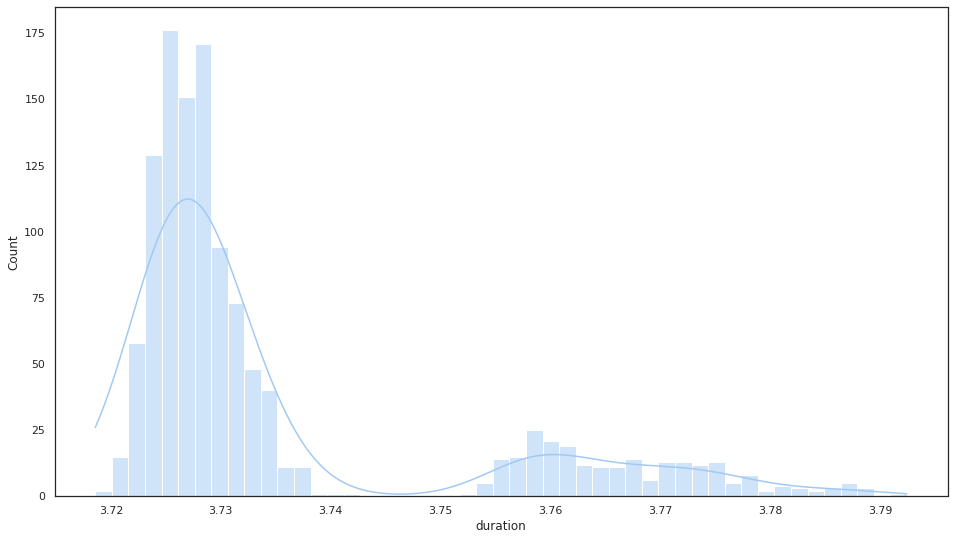

In [21]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.histplot(df['duration'], kde=True, ax=ax)
print(f'Mean: {df["duration"].mean():.3f}')
print(f'Standard deviation: {df["duration"].std():.5f}')

## Epoch duration

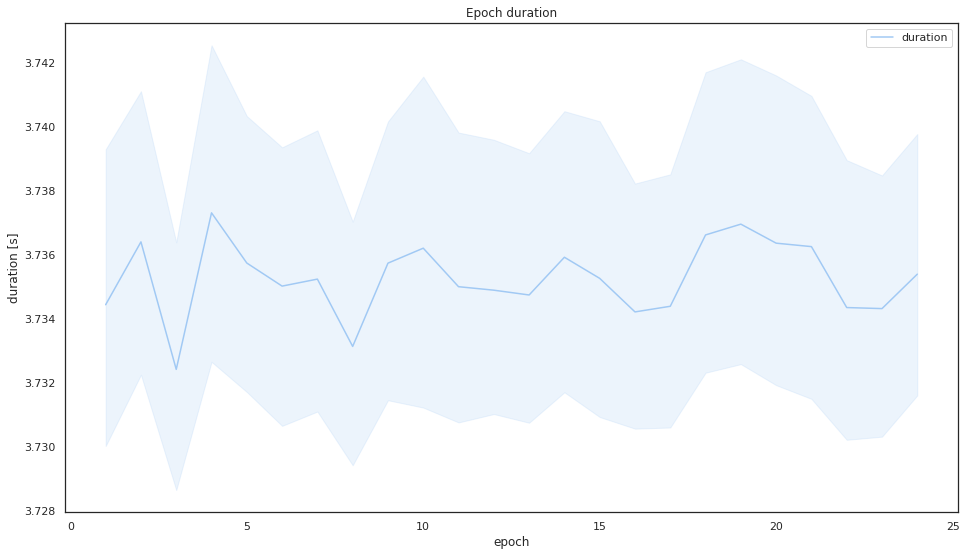

In [22]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(data=df.set_index('epoch')[['duration']], ax=ax)
ax.set_ylabel('duration [s]')
ax.set_title('Epoch duration');

## Accuracies over time

The objective of this model is to achieve 94% validation accuracy in the least amount of time. The desired accuracy is reached on most runs.

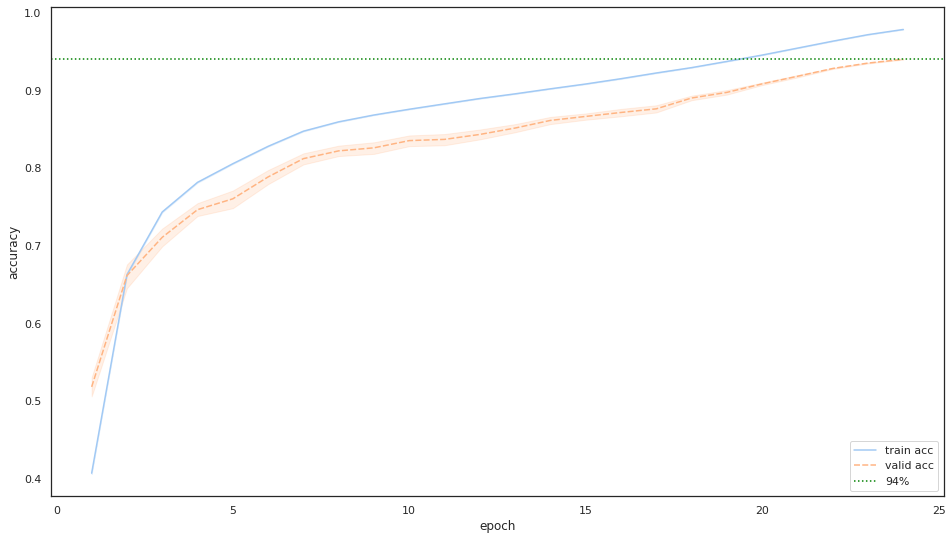

In [23]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(data=df.set_index('epoch')[['train acc', 'valid acc']], ax=ax)
ax.axhline(0.94, linestyle=':', color='green', label='94%')
ax.set_ylabel('accuracy')
ax.legend();

## Cumulative energy consumption versus epoch

In [24]:
df_cum_energy_epoch = df.set_index('epoch').groupby(level='epoch').mean().filter(regex='energy').cumsum()

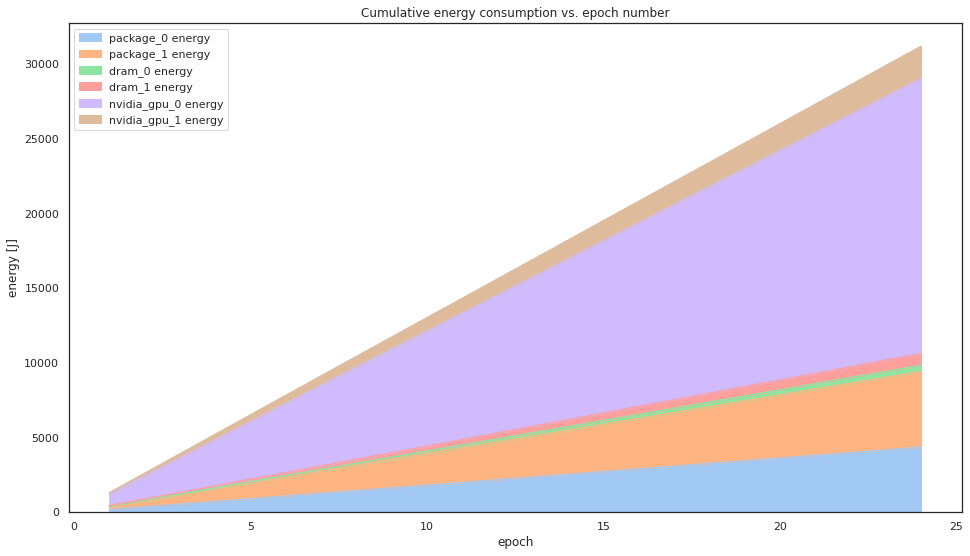

In [25]:
fig, ax = plt.subplots(figsize=(16, 9))
df_cum_energy_epoch.plot.area(ax=ax, ylabel='energy [J]', title='Cumulative energy consumption vs. epoch number');

## Cumulative energy consumption versus accuracy

As validation accuracy increases, the energy required for subsequent improvements grows considerably.

In [26]:
df_cum_energy_validacc = df.set_index('epoch').groupby(level='epoch').mean().set_index('valid acc').filter(regex='energy').cumsum()

In [27]:
acc_points = [0.6, 0.7, 0.8, 0.9]

series_cum_energy_validacc = df_cum_energy_validacc.sum(axis=1)
missing_accs = pd.Series({point: np.nan for point in acc_points})
series_cum_energy_validacc_interp = series_cum_energy_validacc.append(missing_accs).sort_index().interpolate(method='index')
energy_points = [series_cum_energy_validacc_interp[point] for point in acc_points]

print(f'Total energy consumed: {series_cum_energy_validacc.iloc[-1]:.2f}')

Total energy consumed: 31174.36


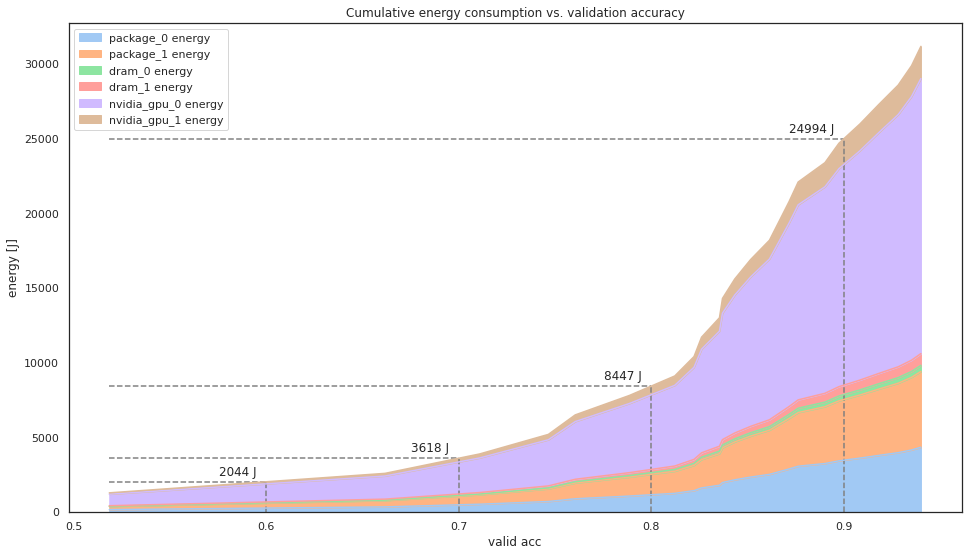

In [28]:
fig, ax = plt.subplots(figsize=(16, 9))
df_cum_energy_validacc.plot.area(ax=ax, ylabel='energy [J]', title='Cumulative energy consumption vs. validation accuracy')

ax.vlines(acc_points, 0, energy_points, color='gray', linestyle="dashed")
ax.hlines(energy_points, df_cum_energy_validacc.index[0], acc_points, color='gray', linestyle="dashed")

for x_point, y_point in zip(acc_points, energy_points):
    ax.text(x_point-0.005, y_point+400, f'{round(y_point)} J', horizontalalignment='right')

In [29]:
for i in range(len(acc_points) - 1):
    print(f'{int(acc_points[i]*100)}% → {int(acc_points[i+1]*100)}%: {round((energy_points[i+1] / energy_points[i] - 1) * 100)}% more energy')

60% → 70%: 77% more energy
70% → 80%: 133% more energy
80% → 90%: 196% more energy


## GPU Power

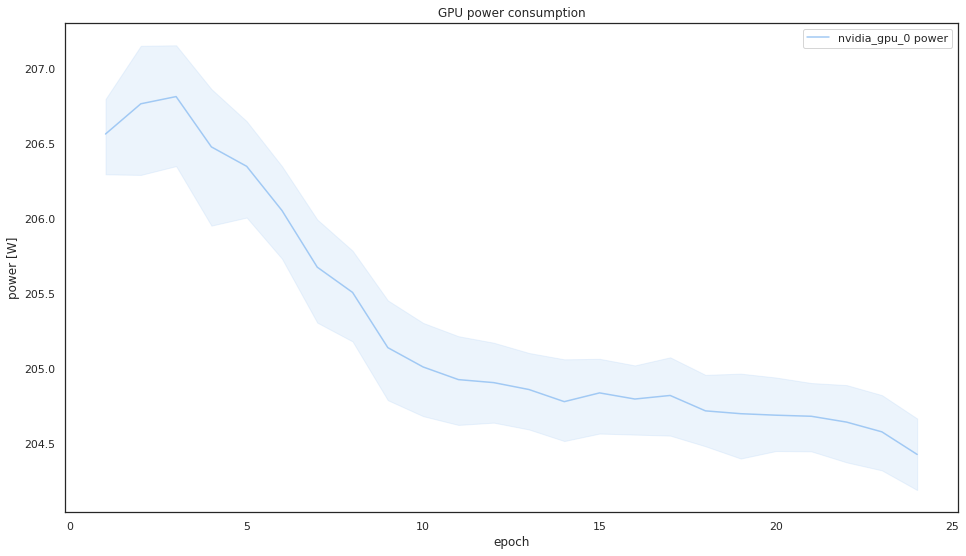

In [30]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(data=df.set_index('epoch')[['nvidia_gpu_0 power']], ax=ax)
ax.set_ylabel('power [W]')
ax.set_title('GPU power consumption')
ax.legend();

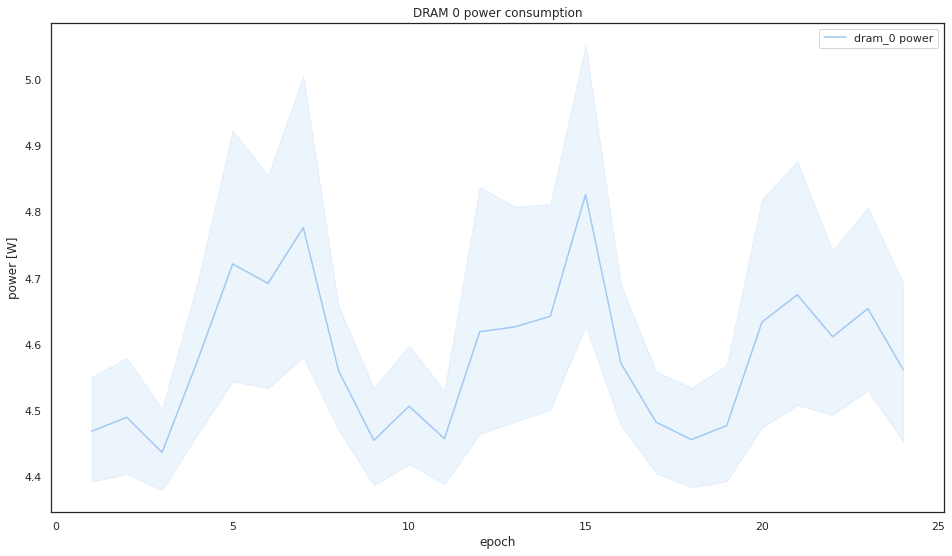

In [31]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(data=df.set_index('epoch')[['dram_0 power']], ax=ax)
ax.set_ylabel('power [W]')
ax.set_title('DRAM 0 power consumption')
ax.legend();

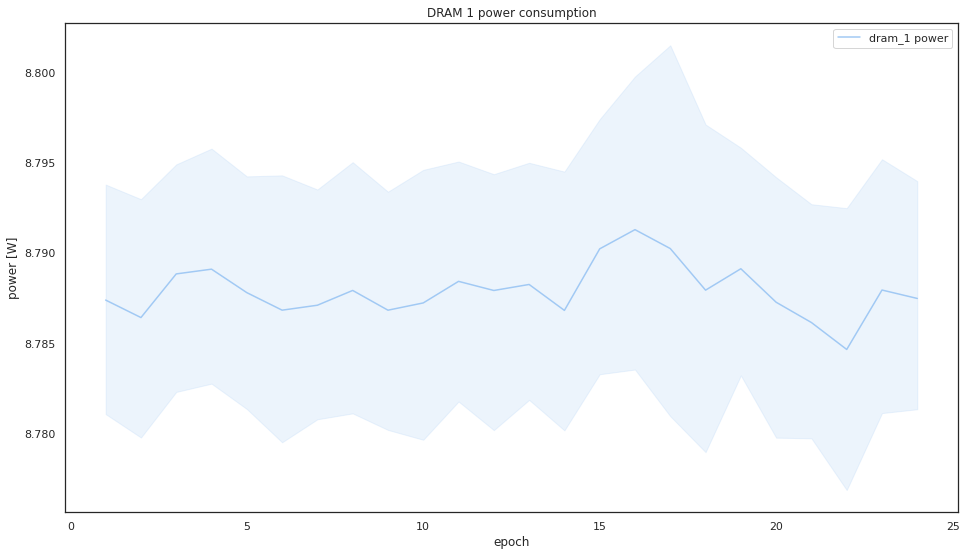

In [32]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(data=df.set_index('epoch')[['dram_1 power']], ax=ax)
ax.set_ylabel('power [W]')
ax.set_title('DRAM 1 power consumption')
ax.legend();

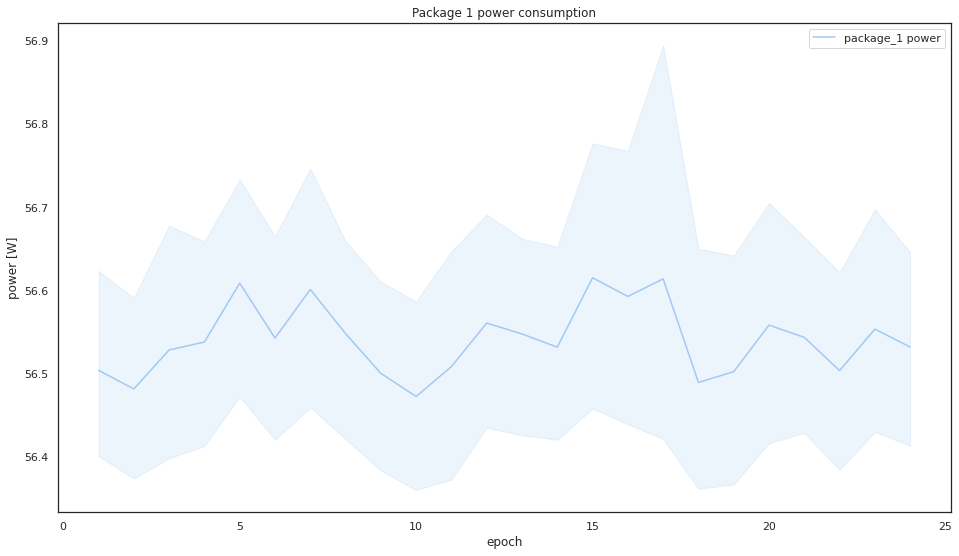

In [33]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(data=df.set_index('epoch')[['package_1 power']], ax=ax)
ax.set_ylabel('power [W]')
ax.set_title('Package 1 power consumption')
ax.legend();

## Energy versus duration

These graphs compare the energy consumption to the duration of an epoch. The colors represent the epoch number inside its respective run.

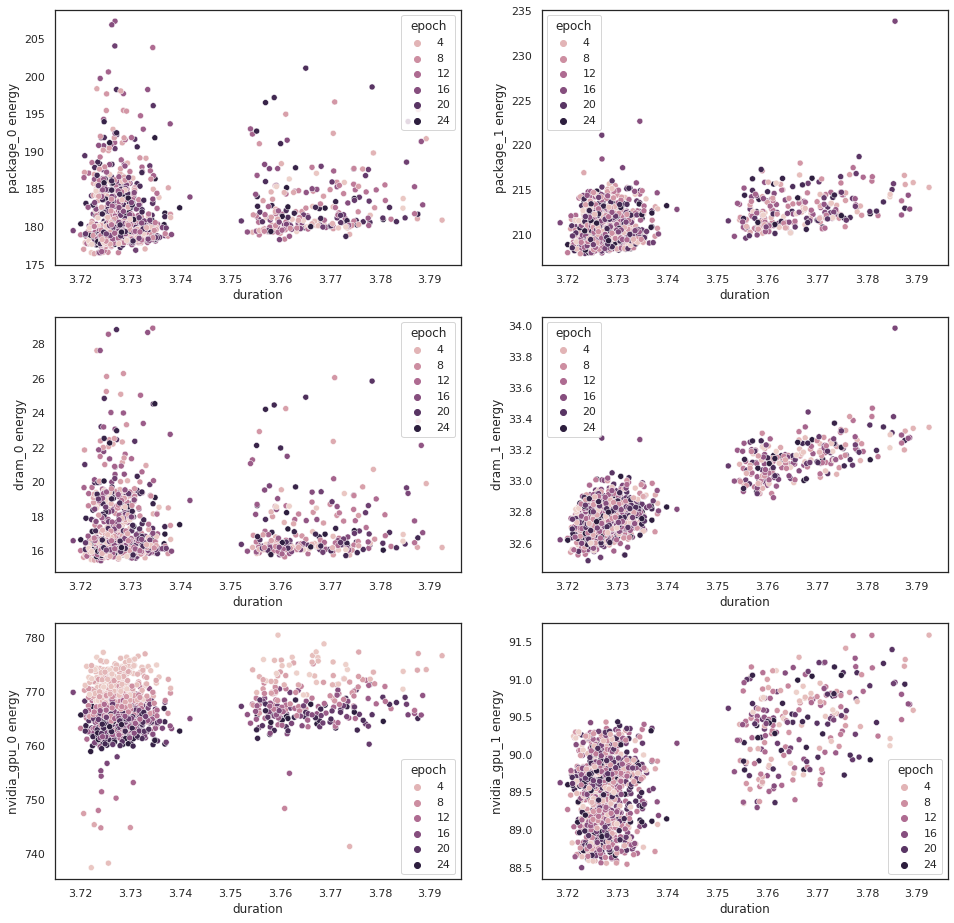

In [34]:
fig, axs = plt.subplots(3, 2, figsize=(16, 16))
sns.scatterplot(data=df, x='duration', y='package_0 energy', ax=axs[0][0], hue='epoch')
sns.scatterplot(data=df, x='duration', y='package_1 energy', ax=axs[0][1], hue='epoch')
sns.scatterplot(data=df, x='duration', y='dram_0 energy', ax=axs[1][0], hue='epoch')
sns.scatterplot(data=df, x='duration', y='dram_1 energy', ax=axs[1][1], hue='epoch')
sns.scatterplot(data=df, x='duration', y='nvidia_gpu_0 energy', ax=axs[2][0], hue='epoch')
sns.scatterplot(data=df, x='duration', y='nvidia_gpu_1 energy', ax=axs[2][1], hue='epoch');

## Power versus duration

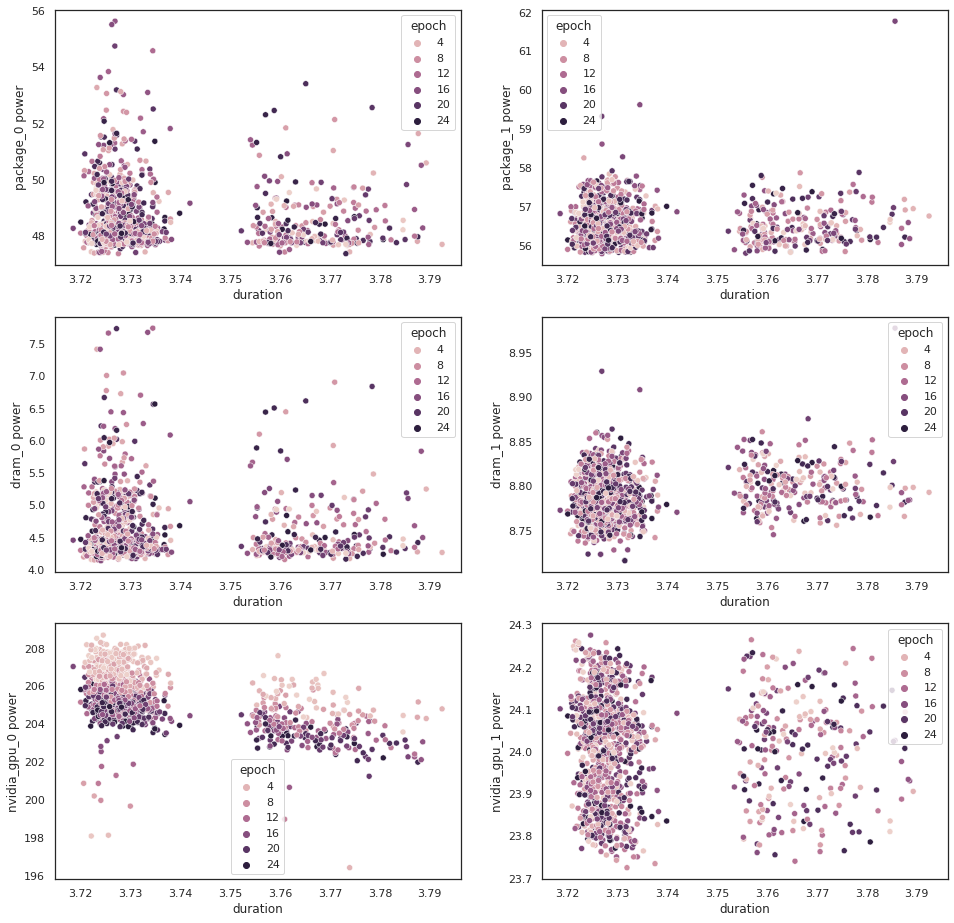

In [35]:
fig, axs = plt.subplots(3, 2, figsize=(16, 16))
sns.scatterplot(data=df, x='duration', y='package_0 power', ax=axs[0][0], hue='epoch')
sns.scatterplot(data=df, x='duration', y='package_1 power', ax=axs[0][1], hue='epoch')
sns.scatterplot(data=df, x='duration', y='dram_0 power', ax=axs[1][0], hue='epoch')
sns.scatterplot(data=df, x='duration', y='dram_1 power', ax=axs[1][1], hue='epoch')
sns.scatterplot(data=df, x='duration', y='nvidia_gpu_0 power', ax=axs[2][0], hue='epoch')
sns.scatterplot(data=df, x='duration', y='nvidia_gpu_1 power', ax=axs[2][1], hue='epoch');

## Energy pair plots

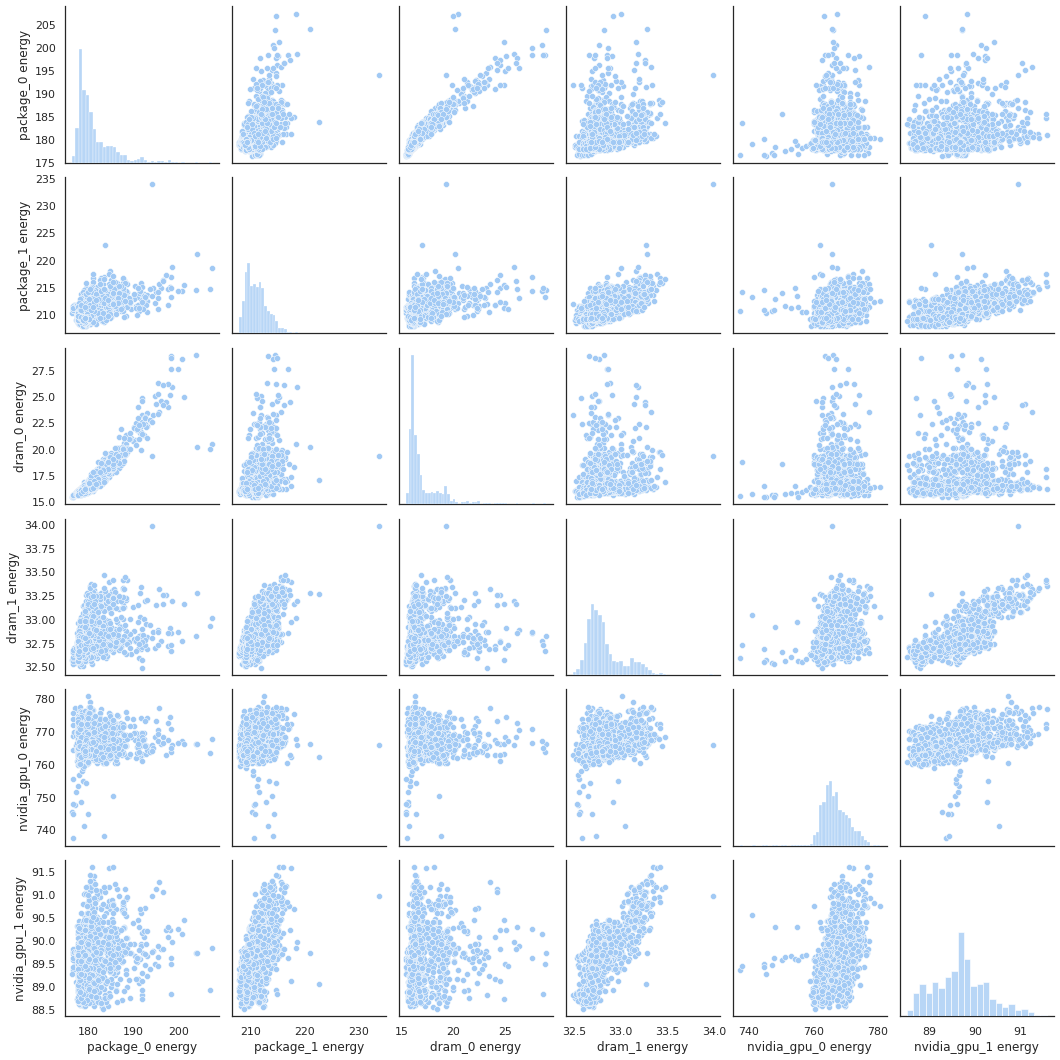

In [36]:
sns.pairplot(df.filter(regex='energy'));

## Power pair plots

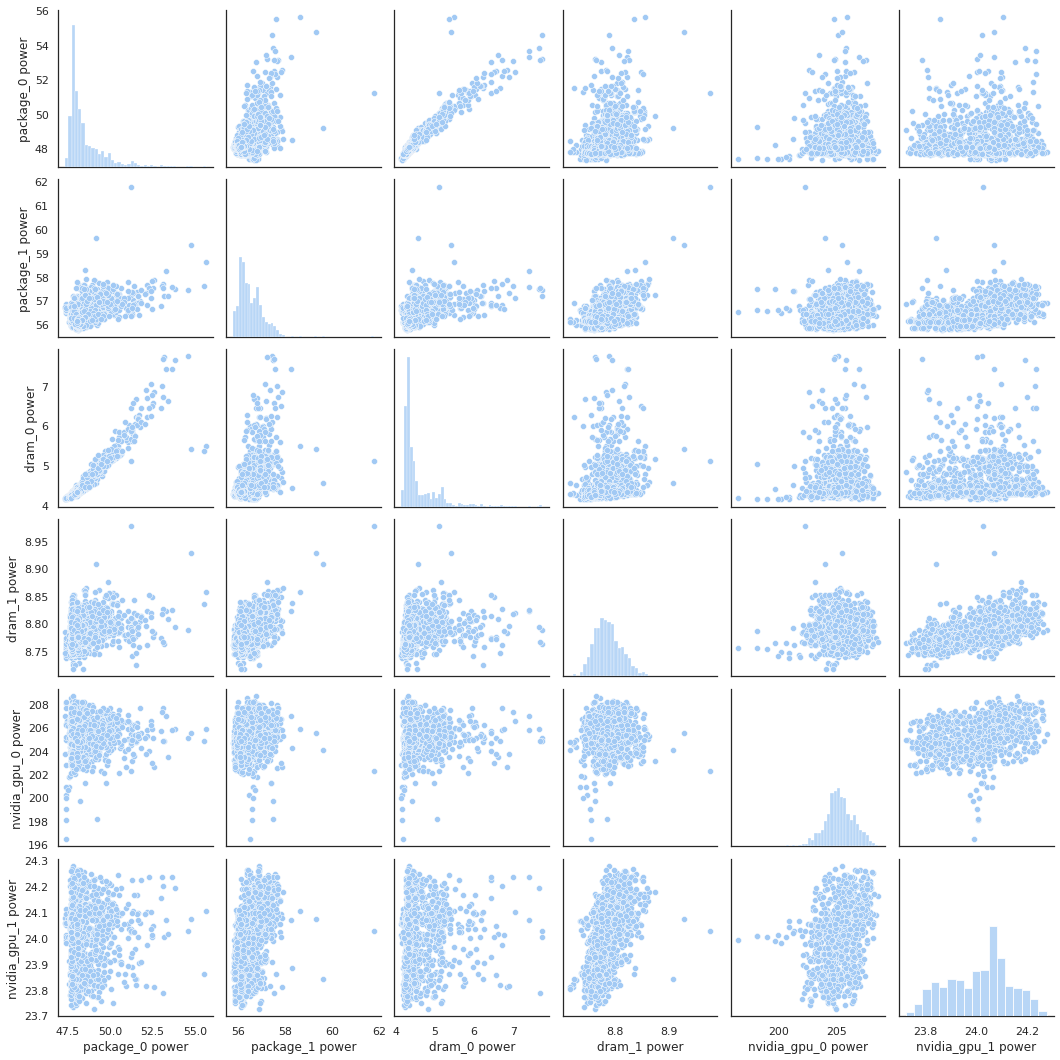

In [37]:
sns.pairplot(df.filter(regex='power'));

## Correlation matrix

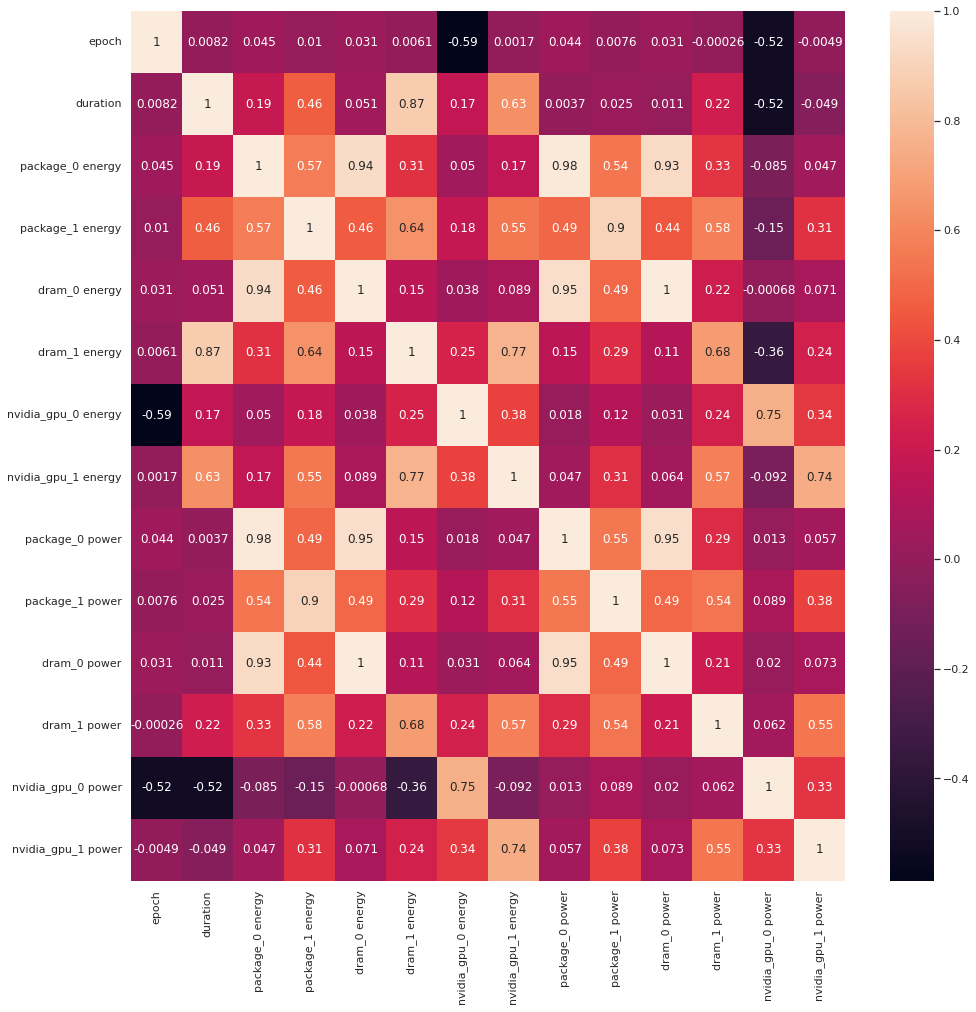

In [38]:
fig, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(
    df
    .drop(['train acc'], axis=1)
    .drop(['valid acc'], axis=1)
    .corr(),
    annot=True,
    ax=ax);